In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import warnings

warnings.filterwarnings("ignore")


In [3]:
class EyeDiseaseDataset:
    def __init__(self, data_dir):
        self.data_dir = data_dir

    def data_paths(self):
        filepaths = []
        labels = []
        folds = os.listdir(self.data_dir)
        for fold in folds:
            fold_path = os.path.join(self.data_dir, fold)
            filelist = os.listdir(fold_path)
            for file in filelist:
                fpath = os.path.join(fold_path, file)
                filepaths.append(fpath)
                labels.append(fold)
        return filepaths, labels

    def data_frame(self, files, labels):
        fseries = pd.Series(files, name='filepaths')
        lseries = pd.Series(labels, name='labels')
        return pd.concat([fseries, lseries], axis=1)

    def split_(self):
        files, labels = self.data_paths()
        df = self.data_frame(files, labels)
        strat = df['labels']
        train_data, dummy_data = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=strat)
        strat = dummy_data['labels']
        valid_data, test_data = train_test_split(dummy_data, train_size=0.5, shuffle=True, random_state=42, stratify=strat)
        return train_data, valid_data, test_data

    # def train_test_split(self, df, test_size=0.2, random_state=42):
    #     return train_test_split(df, test_size=test_size, random_state=random_state, stratify=df['labels'])

In [4]:

data_dir = '/content/drive/My Drive/Colab Notebooks/dataset_resize(2)'

In [5]:
data_split = EyeDiseaseDataset(data_dir)
train_data, valid_data, test_data = data_split.split_()

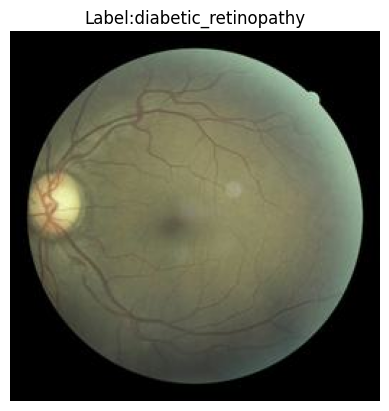

In [6]:

def display_random_image(df):
    random_row = df.sample(1).iloc[0]
    filepath = random_row['filepaths']
    label = random_row['labels']

    img = Image.open(filepath)
    plt.imshow(img)
    plt.title(f'Label:{label}')
    plt.axis('off')
    plt.show()

display_random_image(train_data)

In [7]:
class EyeDiseaseDatasetPyTorch(Dataset):
    def __init__(self, dataframe, label_map, transform=None):
    # def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.label_map = label_map
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx, 1]
        label = self.label_map[label]  # Convert label to integer index

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
# Create a label map
unique_labels = train_data['labels'].unique()
label_map = {label: idx for idx, label in enumerate(unique_labels)}

# Print the label map to verify
print(label_map)

{'diabetic_retinopathy': 0, 'normal': 1, 'cataract': 2}


In [9]:
def augment_data(train_df, valid_df, test_df, label_map, batch_size=32):
# def augment_data(train_df, valid_df, test_df, batch_size=16):
    # img_size = (256, 256)

    train_transform = transforms.Compose([
        # transforms.Resize(img_size),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.5, contrast=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    valid_test_transform = transforms.Compose([
        # transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = EyeDiseaseDatasetPyTorch(train_df, label_map, transform=train_transform)
    valid_dataset = EyeDiseaseDatasetPyTorch(valid_df, label_map, transform=valid_test_transform)
    test_dataset = EyeDiseaseDatasetPyTorch(test_df, label_map, transform=valid_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("Shape of augmented training images:", next(iter(train_loader))[0].shape)
    print("Shape of validation images:", next(iter(valid_loader))[0].shape)
    print("Shape of test images:", next(iter(test_loader))[0].shape)

    return train_loader, valid_loader, test_loader

In [10]:
train_loader, valid_loader, test_loader = augment_data(train_data, valid_data, test_data, label_map)

Shape of augmented training images: torch.Size([32, 3, 256, 256])
Shape of validation images: torch.Size([32, 3, 256, 256])
Shape of test images: torch.Size([32, 3, 256, 256])


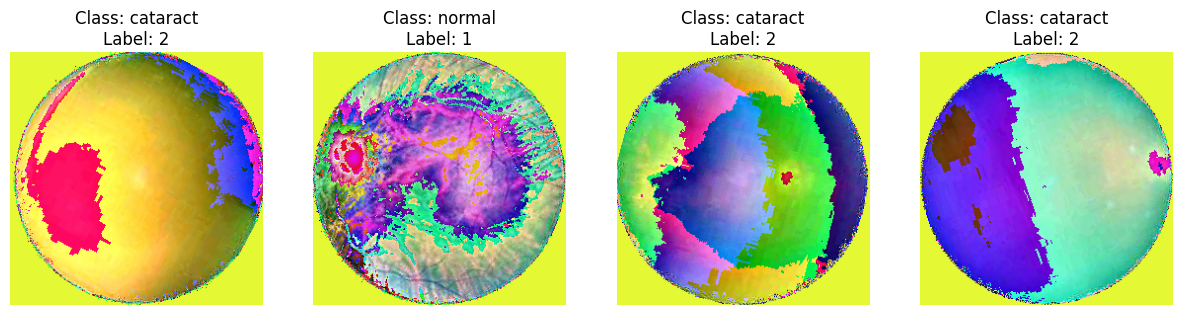

In [11]:
# Assuming label_map is available
# label_map = {'class_name_1': 0, 'class_name_2': 1, ..., 'class_name_n': n-1}
reverse_label_map = {v: k for k, v in label_map.items()}

def show_images(loader, batch_size=16):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images.numpy()

    fig, axes = plt.subplots(1, min(batch_size, 4), figsize=(15, 15))
    for idx in range(min(batch_size, 4)):
        ax = axes[idx]
        img = np.transpose(images[idx], (1, 2, 0)) * 255  # Scale images to [0, 255]
        img = img.astype(np.uint8)  # Convert to unsigned 8-bit integer type
        label_idx = labels[idx].item()
        class_name = reverse_label_map[label_idx]
        ax.imshow(img)
        ax.set_title(f'Class: {class_name}\nLabel: {label_idx}')
        ax.axis('off')
    plt.show()

show_images(train_loader)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        self.base_model = models.vgg16(pretrained=True)
        self.base_model.classifier[6] = nn.Linear(self.base_model.classifier[6].in_features, num_classes)

        # Freeze all layers except the final fully connected layer
        for name, param in self.base_model.named_parameters():
            if "classifier.6" in name:  # Unfreeze the final fully connected layer
                param.requires_grad = True
            else:
                param.requires_grad = False

    def forward(self, x):
        x = self.base_model(x)
        y_pred = nn.ReLU()(x)
        return y_pred

Using device: cuda


In [13]:
import copy
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

In [14]:
num_classes = len(train_data['labels'].unique())
model = VGG16(num_classes).to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
es = EarlyStopping()

num_epochs = 75
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 104MB/s] 


VGG16(
  (base_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16

In [15]:


# Instantiate EarlyStopping
early_stopping = EarlyStopping(patience=5, min_delta=0, restore_best_weights=True)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy}%")

    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0


    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    val_accuracy = 100 * correct_valid / total_valid

    history['val_loss'].append(avg_valid_loss)
    history['val_acc'].append(val_accuracy)

    print(f'Validation Loss: {avg_valid_loss}, Validation Accuracy: {val_accuracy}%')

    # Call early stopping
    if early_stopping(model, avg_valid_loss):
        print("Early stopping")
        break

Epoch 1/75, Train Loss: 1.0537193609135491, Train Accuracy: 43.96355353075171%
Validation Loss: 1.0271761119365692, Validation Accuracy: 66.36363636363636%
Epoch 2/75, Train Loss: 1.057073759181159, Train Accuracy: 43.394077448747154%
Validation Loss: 0.9995955526828766, Validation Accuracy: 67.27272727272727%
Epoch 3/75, Train Loss: 1.031215135540281, Train Accuracy: 48.9749430523918%
Validation Loss: 0.9695475846529007, Validation Accuracy: 67.27272727272727%
Epoch 4/75, Train Loss: 0.9846145957708359, Train Accuracy: 55.58086560364465%
Validation Loss: 0.9549853503704071, Validation Accuracy: 67.27272727272727%
Epoch 5/75, Train Loss: 0.9681353569030762, Train Accuracy: 56.37813211845103%
Validation Loss: 0.9300682842731476, Validation Accuracy: 67.27272727272727%
Epoch 6/75, Train Loss: 0.9351538270711899, Train Accuracy: 60.478359908883824%
Validation Loss: 0.9026291370391846, Validation Accuracy: 68.18181818181819%
Epoch 7/75, Train Loss: 0.9005808510950634, Train Accuracy: 62.87

In [16]:
print("History:", history)

History: {'train_loss': [1.0537193609135491, 1.057073759181159, 1.031215135540281, 0.9846145957708359, 0.9681353569030762, 0.9351538270711899, 0.9005808510950634, 0.8847040661743709, 0.8668135021414075, 0.8416775933333805, 0.8131323733500072, 0.8012856308903012, 0.7723087200096675, 0.762925311923027, 0.7403038569859096, 0.7382823207548687, 0.7048133952277047, 0.6947932860680989, 0.6777171620300838, 0.6766958832740784, 0.659974992275238, 0.6511516592332295, 0.64865870986666, 0.6265399030276707, 0.6325754544564656, 0.6168256827763149, 0.6195392502205712, 0.5980751578296933, 0.5829719060233661, 0.5945511768971171, 0.5793696226818221, 0.5694683247378894, 0.5785846199308123, 0.5519372852785247, 0.5476834146039826, 0.5536793991923332, 0.5481243857315609, 0.5470192240817207, 0.5429753458925656, 0.5320871472358704, 0.5219534018210003, 0.5221088762794223, 0.5290373361536435, 0.5201174840331078, 0.5102636963129044], 'train_acc': [43.96355353075171, 43.394077448747154, 48.9749430523918, 55.580865

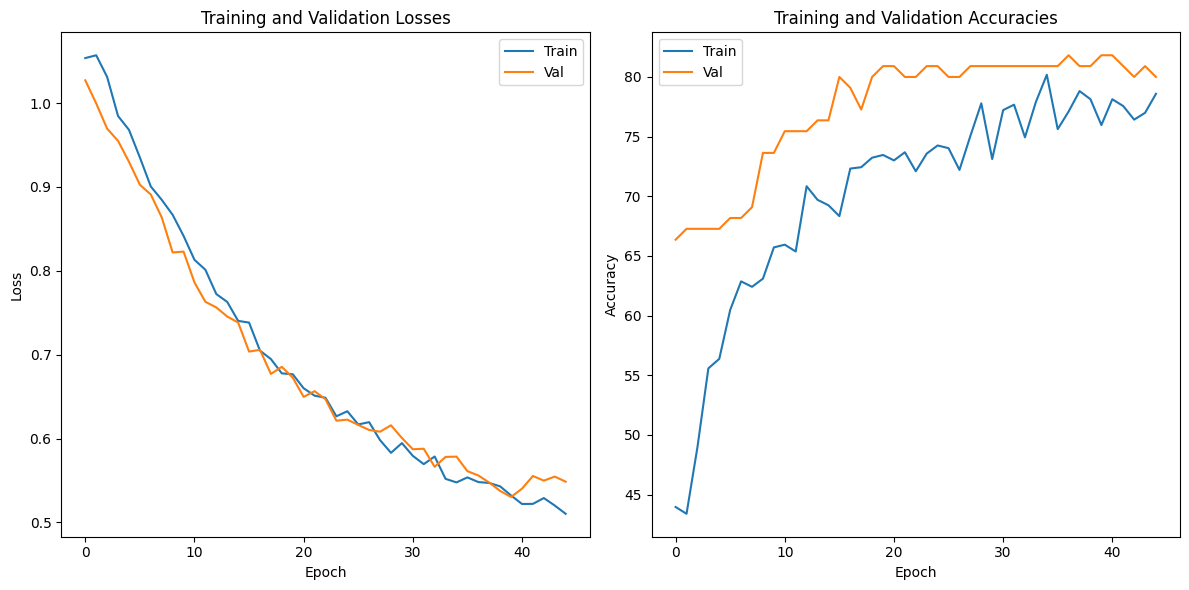

In [17]:
# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracies')

plt.tight_layout()
plt.show()

In [18]:

# Save the model
torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/vgg16_model(v6).pth')

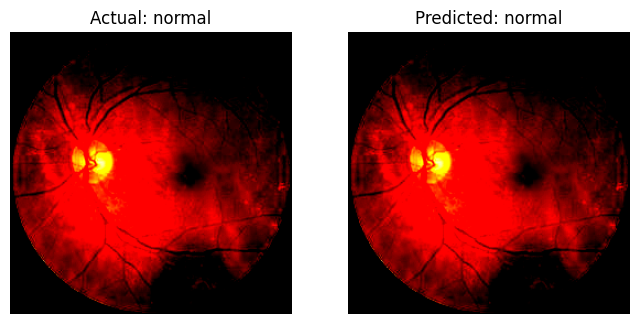

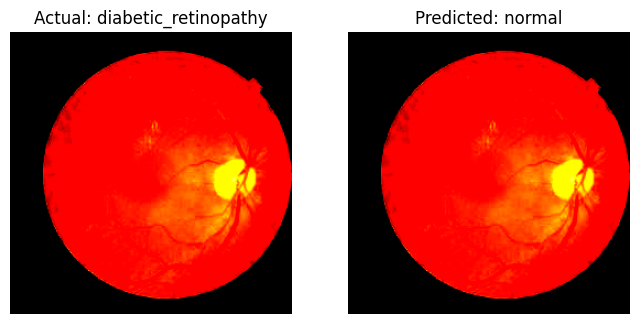

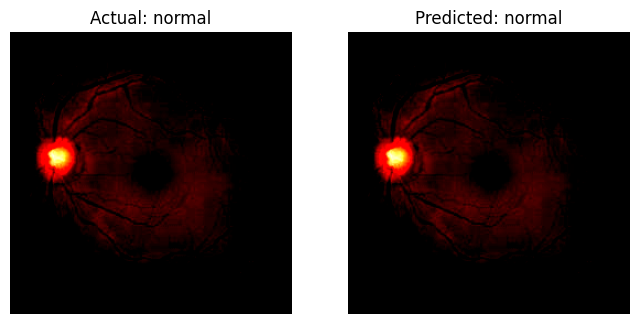

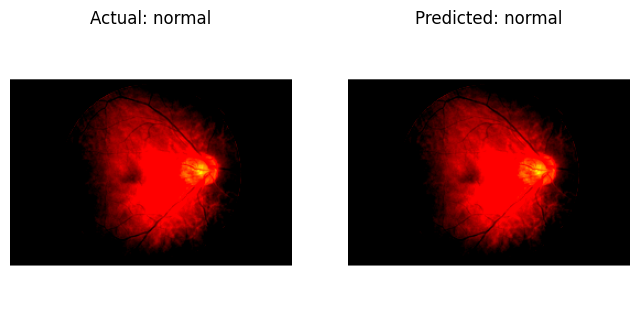

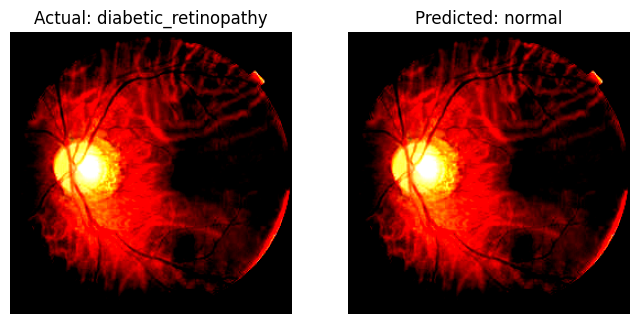

In [19]:
def plot_actual_vs_predicted(model, test_loader, num_samples=5):
    model.eval()
    class_labels = list(train_data['labels'].unique())
    images, labels = next(iter(test_loader))
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    sample_indices = np.random.choice(range(len(images)), num_samples, replace=False)

    for i in sample_indices:
        actual_label = class_labels[labels[i].item()]
        predicted_label = class_labels[predicted[i].item()]
        plt.figure(figsize=(8, 4))
        # Actual Image
        plt.subplot(1, 2, 1)
        plt.imshow(images[i].cpu().permute(1, 2, 0).numpy())
        plt.title(f'Actual: {actual_label}')
        plt.axis('off')
        # Predicted Image
        plt.subplot(1, 2, 2)
        plt.imshow(images[i].cpu().permute(1, 2, 0).numpy())
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()

plot_actual_vs_predicted(model, test_loader)


# Unseen Image

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the pretrained VGG model
model = models.vgg16(pretrained=False)
num_classes = len(train_data['labels'].unique())
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Load the state_dict
state_dict = torch.load('/content/drive/My Drive/Colab Notebooks/vgg16_model(v6).pth')  # Update with your model's path

# Remove the 'base_model.' prefix from state_dict keys
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('base_model.', '')  # remove 'base_model.' prefix
    new_state_dict[name] = v

# Load the modified state_dict
model.load_state_dict(new_state_dict)
model = model.to(device)
model.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:

# Define the image transformations (same as during training)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [22]:

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image.to(device)

def predict(image_path):
    image = load_image(image_path)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return predicted.item()

Image: cataract_525.jpg | Predicted Class: 2 | Predicted Class name: cataract
Image: normal_591.png | Predicted Class: 1 | Predicted Class name: normal
Image: cataract_266.jpg | Predicted Class: 2 | Predicted Class name: cataract
Image: cataract_603.png | Predicted Class: 1 | Predicted Class name: normal
Image: normal_581.png | Predicted Class: 1 | Predicted Class name: normal
Image: cataract_225.jpg | Predicted Class: 2 | Predicted Class name: cataract
Image: cataract_440.jpg | Predicted Class: 2 | Predicted Class name: cataract
Image: cataract_436.jpg | Predicted Class: 2 | Predicted Class name: cataract
Image: cataract_516.jpg | Predicted Class: 2 | Predicted Class name: cataract
Image: normal_514.png | Predicted Class: 1 | Predicted Class name: normal
Image: normal_535.png | Predicted Class: 1 | Predicted Class name: normal
Image: cataract_310.jpg | Predicted Class: 2 | Predicted Class name: cataract
Image: cataract_417.jpg | Predicted Class: 2 | Predicted Class name: cataract
Imag

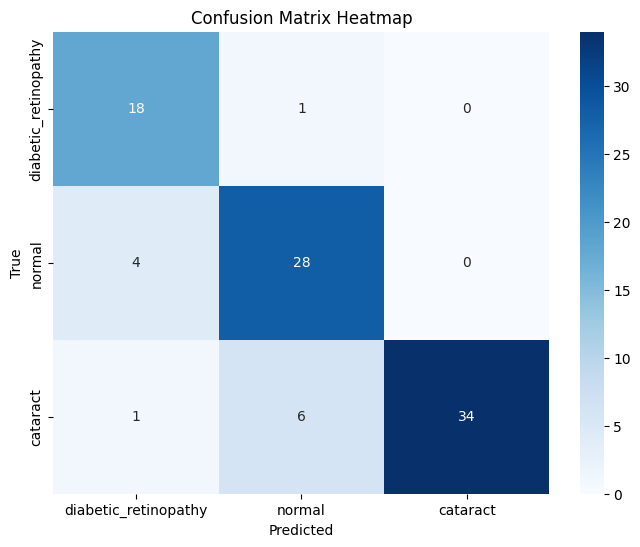

In [38]:
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
unseen_images_dir = '/content/drive/My Drive/Colab Notebooks/test'
image_paths = []
class_names = {
    0: 'diabetic_retinopathy',
    1: 'normal',
    2: 'cataract'
}

# Class mapping based on folder names
folder_class_mapping = {
    'diabetic_retinopathy': 0,
    'normal': 1,
    'cataract': 2
}

ground_truth = {}

# Walk through the directory structure
for root, dirs, files in os.walk(unseen_images_dir):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            # Get the folder name
            folder_name = os.path.basename(root)
            if folder_name in folder_class_mapping:
                # Add the file path and class label to ground_truth
                ground_truth[file] = folder_class_mapping[folder_name]
                image_paths.append(os.path.join(root, file))

random.shuffle(image_paths)

# Placeholder for results
results = []
y_true = []
y_pred = []

# Loop through the unseen images and make predictions
for image_path in image_paths:
    prediction = predict(image_path)
    filename = os.path.basename(image_path)
    predicted_class_name = class_names[prediction]
    true_class = ground_truth.get(filename, None)

    if true_class is not None:
        y_true.append(true_class)
        y_pred.append(prediction)

    # Append results with metrics
    results.append({
        'Image': filename,
        'Predicted Class': prediction,
        'Predicted Class Name': predicted_class_name,
        'True Class': true_class,
    })
    print(f"Image: {filename} | Predicted Class: {prediction} | Predicted Class name: {predicted_class_name}")


if y_true and y_pred:
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    # Print the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names.values()))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Print confusion matrix
    print("\nConfusion Matrix:")
    print(cm)

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()
else:
    accuracy = precision = recall = f1 = float('nan')
    print("No valid predictions to calculate metrics.")

# Update the results with metrics
for result in results:
    result.update({
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Convert results to DataFrame
df = pd.DataFrame(results)

# Save DataFrame to CSV
df.to_csv('/content/drive/My Drive/Colab Notebooks/predictions_unseen_images8.csv', index=False)

In [39]:
import torch
from sklearn.metrics import classification_report

def get_predictions(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

# Ensure the model is on the same device as the data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Get true labels and predictions
y_true, y_pred = get_predictions(model, test_loader, device)

# Assuming label_map is a dictionary mapping from class index to class name
class_names = ['diabetic_retinopathy', 'normal', 'cataract']
# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)
print(cm)

                      precision    recall  f1-score   support

diabetic_retinopathy       0.94      0.46      0.62        35
              normal       0.66      0.97      0.79        38
            cataract       0.97      0.97      0.97        37

            accuracy                           0.81       110
           macro avg       0.86      0.80      0.79       110
        weighted avg       0.85      0.81      0.80       110

Confusion Matrix
[[16 18  1]
 [ 1 37  0]
 [ 0  1 36]]


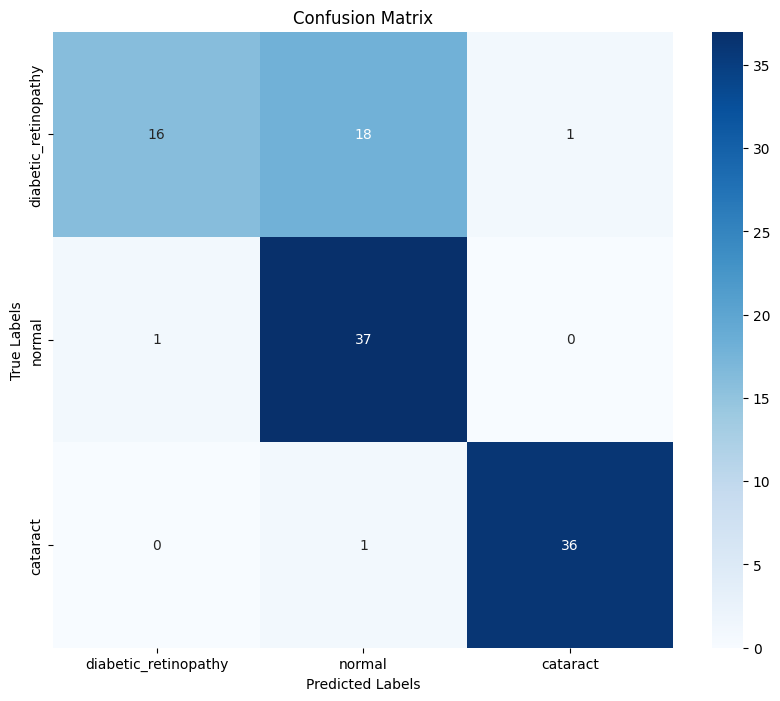

In [40]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()